# Build doc2vec embedding model w/ public-domain DNS log data
This example builds a vector embedding model from sample dns data using doc2vec.
Source data: http://www.secrepo.com/maccdc2012/dns.log.gz 

Building a vector embedding model using Doc2Vec (from the Gensim library) involves converting text documents into dense vector representations. These vector embeddings capture semantic information about the text, allowing you to use them for tasks such as document similarity, clustering, or classification. Here’s a step-by-step explanation of the process:
1. Understanding Doc2Vec

Doc2Vec is an extension of Word2Vec, which generates vector embeddings for entire documents or sentences rather than individual words. It introduces the concept of document vectors, which represent each document in a continuous vector space. Doc2Vec uses two primary models:

    Distributed Memory (DM): Focuses on predicting a word using both surrounding words and a document vector. It's somewhat similar to how Word2Vec works but also includes the document vector.
    Distributed Bag of Words (DBOW): Focuses on predicting the words in a document using the document vector. It's similar to skip-gram in Word2Vec.

2. Preparing Data

First, you need to organize your text data for training. The data must be preprocessed and tokenized into words. Each document is labeled with a unique ID so that the model can associate each document with its corresponding vector.
Steps for preparing data:

    Tokenization: Split your text into tokens (words).
    Remove stop words: Optionally, remove common stop words.
    Label your documents: Doc2Vec requires each document to have a unique label, which can be done using TaggedDocument in Gensim.

In this example, each document is tokenized and tagged with a unique ID (e.g., '0', '1', '2').

In [4]:
#! pip install gensim
#! pip install nltk

In [2]:
# Do once to get NLTK tokenizers
#import nltk
#nltk.download('punkt_tab')

In [1]:
from gensim.models.doc2vec import TaggedDocument
from nltk.tokenize import word_tokenize
from gensim.models import Doc2Vec

In [2]:
# Load the DNS log data into a list
filename = 'dns.log'

with open(filename, 'r') as file:
    # Read lines into a list, removing the newline characters
    documents = [line.strip() for line in file.readlines()]  # Treat each line as a separate document

len(documents)  # How many log entries do we have?  Should be 427K...

427935

In [3]:
# Generate the tagged documents
tagged_data = [TaggedDocument(words=word_tokenize(doc.lower()), tags=[str(i)]) for i, doc in enumerate(documents)]


In [4]:
documents[0]  # Take a look at the raw log data...\t are tab characters. First row...

'1331901005.510000\tCWGtK431H9XuaTN4fi\t192.168.202.100\t45658\t192.168.27.203\t137\tudp\t33008\t*\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\t1\tC_INTERNET\t33\tSRV\t0\tNOERROR\tF\tF\tF\tF\t1\t-\t-\tF'

In [5]:
tagged_data[0] # Take a look at the tagged data...first row

TaggedDocument(words=['1331901005.510000', 'cwgtk431h9xuatn4fi', '192.168.202.100', '45658', '192.168.27.203', '137', 'udp', '33008', '*', '\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00', '1', 'c_internet', '33', 'srv', '0', 'noerror', 'f', 'f', 'f', 'f', '1', '-', '-', 'f'], tags=['0'])

3. Define the model parameters


In [6]:

# Parameters:
# vector_size: size of the document vectors
# window: context window size (how many words before and after to look)
# min_count: minimum word frequency
# workers: number of CPU cores to use
# dm: 1 for Distributed Memory (DM), 0 for Distributed Bag of Words (DBOW)

model = Doc2Vec(vector_size=8, window=5, min_count=2, workers=4, dm=1)

# Build vocabulary
model.build_vocab(tagged_data)


4. Training the Model

Training involves optimizing the model weights by predicting words in context and adjusting the document vectors accordingly. The number of epochs controls how many passes over the training data the model makes.

In [7]:
# Train the model
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

# Save the model
model.save("doc2vec-embedding-model_DNSv1.model")


5. Using the Model

Once the model is trained, you can use it to infer document vectors, calculate similarity between documents, or perform other downstream tasks.
Inferring vectors for new documents:

You can infer the vector for new, unseen documents (important for testing and evaluating the model).

In [8]:
# Doing inference

# If the model is not already loaded, can load the model like so:
# from gensim.models import Doc2Vec
model = Doc2Vec.load("doc2vec-embedding-model_DNSv1.model")

#new_doc = word_tokenize("This is a new document")
# First line from dns.log file...we need something to visually examine
new_doc = word_tokenize('1331901005.510000	CWGtK431H9XuaTN4fi	192.168.202.100	45658	192.168.27.203	137	udp	33008	*\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00	1	C_INTERNET	33	SRV	0	NOERROR	F	F	F	F	1	-	-	F')
vector = model.infer_vector(new_doc)
vector


array([-0.24770531,  0.16860287,  0.07276959, -0.32238778,  0.34391066,
       -0.17559938,  0.5203123 , -0.48106503], dtype=float32)

Finding similar documents:


In [9]:
# Use the vector embeddings to find similar documents
similar_docs = model.dv.most_similar([vector], topn=5)
similar_docs
# We should get an exact match since we used a log entry this model was trained on...investigate why not.

[('131332', 0.9562419056892395),
 ('41215', 0.9532216191291809),
 ('39909', 0.947417140007019),
 ('234482', 0.9463363289833069),
 ('49825', 0.9458643198013306)]

6. Evaluating the Model

Evaluation involves measuring how well the model’s document vectors capture meaningful semantic relationships. You can test the similarity of document vectors or use them in downstream tasks like clustering or classification.
For clustering:

    Use clustering algorithms like KMeans, DBSCAN, or others to group documents based on their vector representations.

In [10]:
documents[0]

'1331901005.510000\tCWGtK431H9XuaTN4fi\t192.168.202.100\t45658\t192.168.27.203\t137\tudp\t33008\t*\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\t1\tC_INTERNET\t33\tSRV\t0\tNOERROR\tF\tF\tF\tF\t1\t-\t-\tF'

In [11]:
# Extract document vectors
doc_vectors = [model.dv[i] for i in range(len(documents))]

doc_vectors[0]

array([-0.02516805, -0.06995159, -0.108978  , -0.02764933, -0.33432212,
       -0.24178472, -0.20091422,  0.00483151], dtype=float32)

In [12]:
# Let's pull the documents and the document vectors together into a dataframe so the data is easier to work with
import pandas as pd

df = pd.DataFrame({'document': documents, 'embedding': doc_vectors})

In [13]:
df.shape

(427935, 2)

In [14]:
df.sample(3)

,document,embedding
204601,1331922673.920000\tCjU3fM3OFW6Ms3en2b\t192.168...,"[-0.052768346, 0.061195884, -0.107524134, -0.0..."
271569,1331927876.970000\tCtdfFj9yL3LSG44tl\t192.168....,"[0.039411146, 0.053052314, 0.00971435, -0.0230..."
421433,1332014436.070000\tCAvlcW2Lqg2lkN4Xtj\t192.168...,"[0.080716886, -0.07902379, -0.012096887, -0.10..."


In [18]:
# Let's try DBSCAN clustering

from sklearn.cluster import DBSCAN

#embeddings = df['embedding'].tolist()

# Train the DBSCAN clustering model
dbscan_model = DBSCAN(eps=0.10, min_samples=50, metric='cosine')
#clusters = dbscan_model.fit_predict(embeddings)
clusters = dbscan_model.fit_predict(doc_vectors)

# Add the cluster labels back to the DataFrame
df['cluster_group'] = clusters

# Analyzing the results
n_clusters = len(set(df['cluster_group'])) - (1 if -1 in df['cluster_group'] else 0)
n_noise = list(df['cluster_group']).count(-1)

print(f'Estimated number of DBSCAN clusters: {n_clusters}')
print(f'Estimated number of noise points: {n_noise}')


Estimated number of DBSCAN clusters: 2
Estimated number of noise points: 1190


In [19]:
# We hope to see cluster group counts in the ballpark of 950 and 50
df['cluster_group'].value_counts()


cluster_group
 0    426745
-1      1190
Name: count, dtype: int64

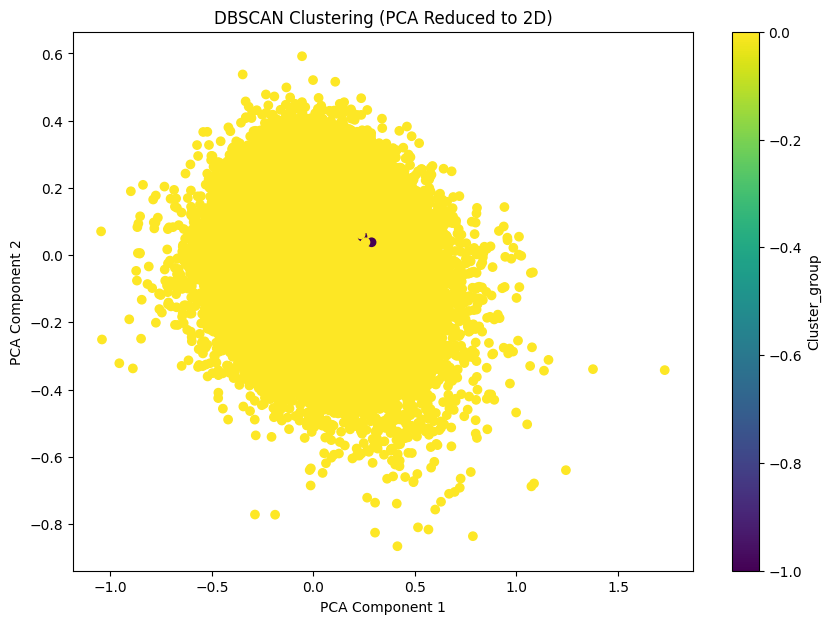

In [23]:
# Plot the results after applying PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce the embeddings to 2 dimensions using PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(doc_vectors)

# Plot
plt.figure(figsize=(10, 7))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=df['cluster_group'], cmap='viridis', marker='o')
plt.title('DBSCAN Clustering (PCA Reduced to 2D)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter, label='Cluster_group')
plt.show()

Summary:

    Prepare the data: Tokenize and tag the documents.
    Build the model: Initialize a Doc2Vec model with appropriate hyperparameters.
    Train the model: Train the model on the tagged document data.
    Infer vectors: Use the trained model to infer vectors for new documents.
    Use the vectors: Perform similarity search, clustering, or other tasks using the document vectors.

